# Markov Drip Process

## Initial setup

In [1]:
import numpy as np
from scipy.optimize import Bounds, minimize
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../python/')
import util
from ephys import Poisson

mountainlab_pytools module not installed. Some functions from the ephys package may not be available.


## Poisson distribution

### Create handling class
Moved to `ephys` module. See `../python/ephys.py` for implementation details.

### Test inter-event time sampling
This should be drawn from an exponential distribution: $t \sim \lambda e^{-\lambda t}$

Expected mean: 2.00000e+00
Actual mean: 2.04531e+00
Expected std: 2.00000e+00
Actual std: 2.03705e+00


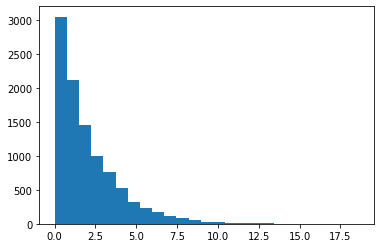

In [2]:
# Settings
lam = 0.5
poisson = Poisson(lam, homogeneous=True)

# Get inter-event times
sample = poisson.times(n=10000, interevent=True)

# Print results
print('Expected mean: %.5e' % (1.0/lam))
print('Actual mean: %.5e' % (np.mean(sample)))
print('Expected std: %.5e' % (1.0/lam))
print('Actual std: %.5e' % (np.std(sample)))

# Plot results
plt.hist(sample, bins=25);

### Test event sampling
This should be drawn from the Poisson distribution: $N(s) \sim Poisson(\lambda s)$

Expected mean: 10.00000
Actual mean: 9.92500
Expected std: 3.16228
Actual std: 3.13901


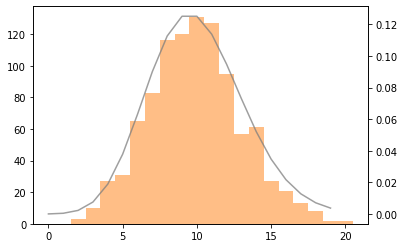

In [3]:
# Settings
lam = 2.0
s = 5.0
iters = 1000

# Create distribution
poisson = Poisson(lam, homogeneous=True)

# Sample number of events
sample = np.zeros(iters, dtype=np.int64)
for i in range(iters):
    sample[i] = poisson.events(s)
    
# Get probabilities of events samples
n_range = np.arange(2*lam*s)
probs = poisson.P(n=n_range, s=s)

# Print results
print('Expected mean: %.5f' % (lam*s))
print('Actual mean: %.5f' % (np.mean(sample)))
print('Expected std: %.5f' % ((lam*s)**0.5))
print('Actual std: %.5f' % (np.std(sample)))

# Plot results
fig, ax = plt.subplots()
ax.hist(sample, bins=np.arange(np.max(sample))+0.5, color='C1', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(n_range, probs, color='C7', alpha=0.75);

### Search parameter space
It might be best to solve for the optimal foraging behavior (e.g. residence time) given a specified environment (e.g. travel time, cumulative reward function). Here, the cumulative reward function is actually based on a non-homogeneous Poisson process in the drip function.

Recall that a Poisson process is given by:
- exponentially distributed variables $t \mid p(t) = \lambda e^{-\lambda t}$
- a random variable $T \mid T_n = t_1 + t_2 + \ldots + t_n$
- a number of events $N \mid N(s) = max\{n \mid T_n \leq s\}$

The underlying statistics of such a process are:

$
\quad P(N(s) = n) = e^{-\lambda s} \frac{(\lambda s)^n}{n!} = Poisson(\lambda s) \\
\quad \mathbb{E}[N(s)] = \lambda s \\
\quad var[N(s)] = \lambda s
$

(We will use $p$ for probability density and $P$ for cumulative probability density. See Appendix for derivation of these statistics.)

When $\lambda$ is constant, the above is termed a *homogeneous* Poisson process. However, if $\lambda$ varies over time, then the process becomes *non-homogeneous* or *inhomogeneous*. In such cases, the process can be modeled as a homogeneous Poisson process over some interval $\left [ t_1, t_2 \right ]$ by replacing $\lambda$ with its integral over that time interval:

$
\quad \Lambda(t, s) = \int_t^{t+s} \lambda(t) dt \\
\quad P_t(N(s) = n) = e^{-\Lambda(t, s)} \frac{(\Lambda(t, s))^n}{n!} = Poisson(\Lambda(t, s)) \\
\quad \mathbb{E}_t[N(s)] = \Lambda(t, s) \\
\quad var_t[N(s)] = \Lambda(t, s)
$

(See Appendix for derivations.)

Given that drip times follow $T \sim Poisson(\Lambda(t, s))$, the mean drip rate is $\frac{\mathbb{E}[N(s)]}{s} = \frac{\Lambda(t, s)}{s}$ (or conversely, the mean inter-drip time is given by $\mathbb{E}_t (t_i - t_{i-1}) = \frac{1}{\Lambda(t, s)}$). The instantaneous fill rate of the bucket is then $\frac{dV}{dt} = lim_{s \to 0} \left ( V_{drip} \Lambda(t, s) \right ) = V_{drip} \lambda(t)$, and the cumulative reward function since time $t$ is:

$
\begin{align}
\quad V 
&= V_{drip} \mathbb{E}_t[N(s)] \\
&= V_{drip} \Lambda(t, s) \\
&= V_{drip} \int_t^{t+s} \lambda(t') dt'
\end{align}
$

In this case, $\lambda(t)$ decays over time:

$\quad \lambda(t) = \lambda_0 e^{-\frac{t}{\tau}}$

So the cumulative reward functions becomes:

$
\begin{align}
\quad V &= V_{drip} \int_t^{t+s} \lambda_0 e^{-\frac{t'}{\tau}} dt' \\
&= \lambda_0 V_{drip} \int_t^{t+s} e^{-\frac{t'}{\tau}} dt' \\
&= \lambda_0 V_{drip} \tau \left ( e^{-\frac{t}{\tau}} - e^{-\frac{t+s}{\tau}} \right )
\end{align}
$

or if $t=0$:

$
\begin{align}
\quad V &= \lambda_0 V_{drip} \tau \left ( 1 - e^{-\frac{s}{\tau}} \right )
\end{align}
$

Looking at the solution to the marginal value theorem for an exponentially decaying reward rate, we see that, on average, the Poisson drip model is in fact equivalent, with $r_0 = \lambda_0 V_{drip}$. Thus searching for parameters in this model amounts to finding the right parameters in the deterministic model ($r_0, R_0, \tau$), and then tuning the Poisson model parameters ($\lambda_0, V_{drip}$) within the constraint that $\lambda_0 V_{drip} = r_0$. While the expected cumulative reward per patch will remain the same, the variance of the cumulative reward per patch will increase as $\lambda_0$ decreases (or, conversely, as $V_{drip}$ increases). Therefore, after finding the right point in parameter space for the deterministic model, the degree of stochasticity can be tuned by varying the product $\lambda_0 V_{drip}$.

## Patch modeling

### Settings

In [10]:
# Settings
lam_drip_0 = 1.0 # initial drip parameter
lam_lick = 1.0/5.0 # lick parameter
lick_timeout = 1.0 # minimum time between rewarded licks
tau = 30.0 # rate of decay of lambda
V_drip = 2.0 # drip volume (uL)
V_reward = 2.0 # reward volume (uL)
t_0 = 0 # initial time (s)
s = 300 # end time (s)
num_patches = 1000

# Poisson parameter functions for drip process
lam_drip = lambda t: lam_drip_0*np.exp(-t/tau) # lambda(t)
Lam_drip = lambda t, s: lam_drip_0*tau*(np.exp(-t/tau) - np.exp(-(t+s)/tau)) # integral

### Method 1: Generate inter-reward intervals
I think this is actually the wrong way to do it!

#### Single patch

In [17]:
# Create initial distribution
mouse = Poisson(lam_lick)
drip = Poisson(lam_drip)

# Placeholders (for debugging)
t_drip = [] # drip times
t_lick = [] # lick times
t_event = []
V_bucket = [] # bucket volume

# Initialize variables
bucket = 0.0 # volume in bucket
t, t_next_drip, t_next_lick = t_0, t_0, t_0
t_prev_reward = -lick_timeout

while (t <= t_0 + s):
    # Increment timer to next event
    t = min(t_next_drip, t_next_lick)
    
    # Update Poisson params
    lam = lam_drip(t)
    drip.lam = lambda t: lam
    drip.Lam = lambda t, s: lam*s
    
    # Handle drip event
    if (t == t_next_drip):
        bucket += V_drip
        t_drip.append(t)
        t_next_drip = t + drip.times(t_max=100.0)
    
    # Handle lick event
    if (t == t_next_lick):
        if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
            bucket -= V_reward
            t_prev_reward = t
        t_lick.append(t)
        t_next_lick = t + mouse.times(t_max=100.0)
        
    # Log bucket volume
    t_event.append(t)
    V_bucket.append(bucket)
    
# Create arrays
t_drip = np.array(t_drip)
t_lick = np.array(t_lick)
t_event = np.array(t_event)
V_bucket = np.array(V_bucket)

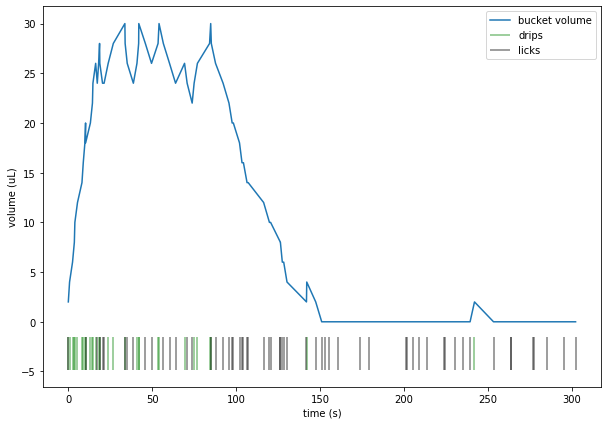

In [18]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

#### Multiple patches

In [23]:
# Create distributions
drip = Poisson(lam_drip)
mouse = Poisson(lam_lick)

# Placeholders
t_drip_all = []
t_lick_all = []
t_event_all = []
V_bucket_all = []

for patch in range(num_patches):
    # Initialize variables
    bucket = 0.0 # volume in bucket
    t, t_next_drip, t_next_lick = t_0, t_0, t_0
    t_prev_reward = -lick_timeout

    # Placeholders (for debugging)
    t_drip = [] # drip times
    t_lick = [] # lick times
    t_event = []
    V_bucket = [] # bucket volume

    while (t <= t_0 + s):
        # Update Poisson params
        lam = lam_drip(t)
        drip.lam = lambda t: lam
        drip.Lam = lambda t, s: lam*s

        # Handle drip event
        if (t == t_next_drip):
            bucket += V_drip
            t_drip.append(t)
            t_next_drip = t + drip.times(t_max=100.0)

        # Handle lick event
        if (t == t_next_lick):
            if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
                bucket -= V_reward
                t_prev_reward = t
            t_lick.append(t)
            t_next_lick = t + mouse.times(t_max=100.0)

        # Log bucket volume
        t_event.append(t)
        V_bucket.append(bucket)
        
        # Increment timer to next event
        t = min(t_next_drip, t_next_lick)
    
    # Log simulation
    t_drip_all.append(np.array(t_drip))
    t_lick_all.append(np.array(t_lick))
    t_event_all.append(np.array(t_event))
    V_bucket_all.append(np.array(V_bucket))

Number of drips from t=0.00 s to t=300.00 s:
	Expected mean: 29.99864
	Actual mean: 35.96100
	Expected std: 5.47710
	Actual std: 5.39402


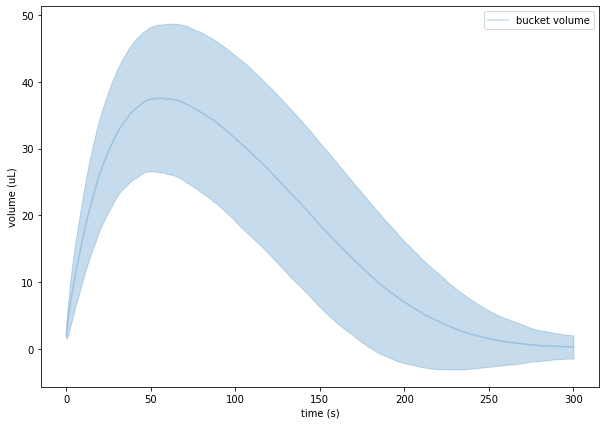

In [24]:
# Check mean and variance of N(s)
N_s = np.zeros([num_patches])
for i in range(num_patches):
    N_s[i] = len(t_drip_all[i])
    
# Print results of N(s)
print('Number of drips from t=%.2f s to t=%.2f s:' % (t_0, s))
print('\tExpected mean: %.5f' % (Lam_drip(t_0, s)))
print('\tActual mean: %.5f' % (np.mean(N_s)))
print('\tExpected std: %.5f' % ((Lam_drip(t_0, s))**0.5))
print('\tActual std: %.5f' % (np.std(N_s)))

# Interpolate for plotting purposes
t_interp = np.linspace(t_0, t_0 + s, num=10*s)
V_interp = np.zeros([num_patches, t_interp.size])
for i in range(num_patches):
    F = interp1d(t_event_all[i], V_bucket_all[i])
    idx_max = np.argwhere(t_interp <= t_event_all[i][-1]).flatten()[-1]
    V_interp[i, :idx_max+1] = F(t_interp[:idx_max+1])
    V_interp[i, idx_max+1:] = F(t_interp[idx_max])

# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
mean = np.mean(V_interp, axis=0)
std = np.std(V_interp, axis=0)
ax.plot(t_interp, mean, color='C0', alpha=0.25, label='bucket volume')
ax.fill_between(t_interp, y1=mean-std, y2=mean+std, color='C0', alpha=0.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

### Method 2: Generate event times and prune
The correct way to generate inhomogeneous Poisson processes.

#### Single patch

In [19]:
# Create distributions
drip = Poisson(lam=lam_drip, Lam=Lam_drip, homogeneous=False)
mouse = Poisson(lam_lick)

# Get drip and lick events
t_drip = drip.times(interevent=False, t=0, s=s, t_max=100)
t_lick = mouse.times(interevent=False, t=0, s=s)

# Placeholders (for debugging)
t_event = []
V_bucket = [] # bucket volume

# There should be a vectorized way to do this...
bucket = 0.0 # volume in bucket
t = t_0
idx_drip = 0
idx_lick = 0
t_prev_reward = -lick_timeout
while (True): 
    # Determine event type
    if (idx_drip < t_drip.size) and (idx_lick < t_lick.size):
        is_drip = (t_drip[idx_drip] < t_lick[idx_lick])
    elif (idx_drip < t_drip.size) and (idx_lick == t_lick.size):
        is_drip = True
    elif (idx_drip == t_drip.size) and (idx_lick < t_lick.size):
        is_drip = False
    else:
        break
    
    # Handle drip event
    if is_drip:
        t = t_drip[idx_drip]
        bucket += V_drip
        idx_drip += 1
    
    # Handle lick event
    else:
        t = t_lick[idx_lick]
        if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
            bucket -= V_reward
            t_prev_reward = t
        idx_lick += 1
        
    # Log bucket volume
    t_event.append(t)
    V_bucket.append(bucket)
    
# Create arrays
t_event = np.array(t_event)
V_bucket = np.array(V_bucket)

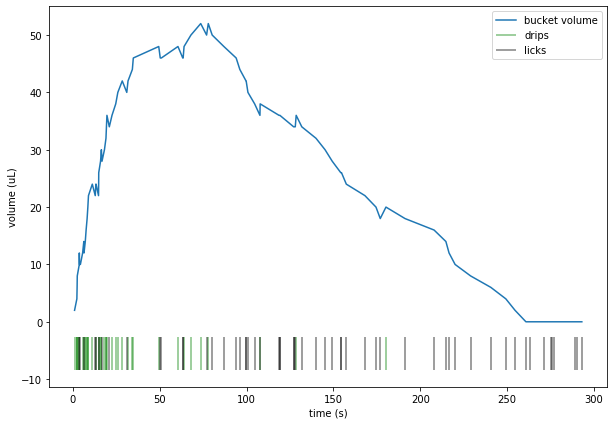

In [20]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(t_event, V_bucket, label='bucket volume')
ymin = ax.get_ylim()[0] - 0.1*np.diff(ax.get_ylim())
ymax = ax.get_ylim()[0]
ax.vlines(t_drip, ymin=ymin, ymax=ymax, color='green', alpha=0.5, label='drips')
ax.vlines(t_lick, ymin=ymin, ymax=ymax, color='black', alpha=0.5, label='licks')
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

#### Multiple patches

In [21]:
# Create distributions
drip = Poisson(lam=lam_drip, Lam=Lam_drip, homogeneous=False)
mouse = Poisson(lam_lick)

# Placeholders
t_drip_all = []
t_lick_all = []
t_event_all = []
V_bucket_all = []

for patch in range(num_patches):
    # Initialize variables
    t = t_0 # current time (s)
    bucket = 0.0 # volume in bucket

    # Get drip and lick events
    t_drip = drip.times(interevent=False, t=t_0, s=s, t_max=100)
    t_lick = mouse.times(interevent=False, t=t_0, s=s)

    # Placeholders (for debugging)
    t_event = []
    V_bucket = [] # bucket volume

    # There should be a vectorized way to do this...
    idx_drip = 0
    idx_lick = 0
    t_prev_reward = -lick_timeout
    while (True): 
        # Determine event type
        if (idx_drip < t_drip.size) and (idx_lick < t_lick.size):
            is_drip = (t_drip[idx_drip] < t_lick[idx_lick])
        elif (idx_drip < t_drip.size) and (idx_lick == t_lick.size):
            is_drip = True
        elif (idx_drip == t_drip.size) and (idx_lick < t_lick.size):
            is_drip = False
        else:
            break

        # Handle drip event
        if is_drip:
            t = t_drip[idx_drip]
            bucket += V_drip
            idx_drip += 1

        # Handle lick event
        else:
            t = t_lick[idx_lick]
            if (bucket >= V_reward) and (t - t_prev_reward > lick_timeout):
                bucket -= V_reward
                t_prev_reward = t
            idx_lick += 1

        # Log bucket volume
        t_event.append(t)
        V_bucket.append(bucket)

    # Log simulation
    t_drip_all.append(t_drip)
    t_lick_all.append(t_lick)
    t_event_all.append(np.array(t_event))
    V_bucket_all.append(np.array(V_bucket))

Number of drips from t=0.00 s to t=300.00 s:
	Expected mean: 29.99864
	Actual mean: 29.85500
	Expected std: 5.47710
	Actual std: 5.24900


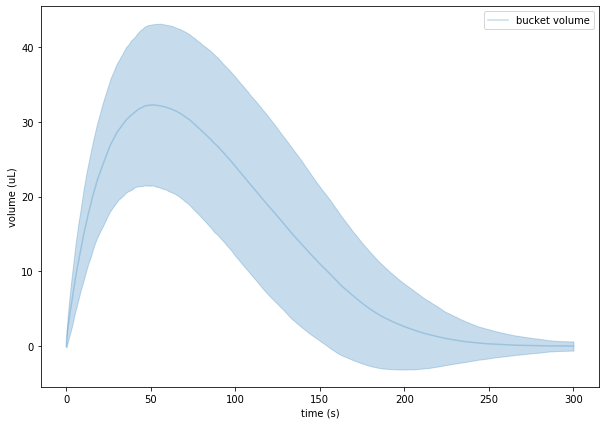

In [22]:
# Check mean and variance of N(s)
N_s = np.zeros([num_patches])
for i in range(num_patches):
    N_s[i] = len(t_drip_all[i])
    
# Print results of N(s)
print('Number of drips from t=%.2f s to t=%.2f s:' % (t_0, s))
print('\tExpected mean: %.5f' % (Lam_drip(t_0, s)))
print('\tActual mean: %.5f' % (np.mean(N_s)))
print('\tExpected std: %.5f' % ((Lam_drip(t_0, s))**0.5))
print('\tActual std: %.5f' % (np.std(N_s)))

# Interpolate for plotting purposes
t_interp = np.linspace(t_0, t_0 + s, num=10*s)
V_interp = np.zeros([num_patches, t_interp.size])
for i in range(num_patches):
    F = interp1d(np.insert(t_event_all[i], 0, 0.0), 
                 np.insert(V_bucket_all[i], 0, 0.0))
    idx_max = np.argwhere(t_interp <= t_event_all[i][-1]).flatten()[-1]
    V_interp[i, :idx_max+1] = F(t_interp[:idx_max+1])
    V_interp[i, idx_max+1:] = F(t_interp[idx_max])

# Plot results
fig, ax = plt.subplots(figsize=(10, 7))
mean = np.mean(V_interp, axis=0)
std = np.std(V_interp, axis=0)
ax.plot(t_interp, mean, color='C0', alpha=0.25, label='bucket volume')
ax.fill_between(t_interp, y1=mean-std, y2=mean+std, color='C0', alpha=0.25)
ax.set_xlabel('time (s)')
ax.set_ylabel('volume (uL)')
ax.legend();

This looks right. In the first method, the mean is too long.

## Appendix

### Homogeneous Poisson process
The mean and variance of a homogeneous Poisson process (that is, $\lambda(t) = k \: \forall \: t$) are given by:

$
\begin{align}
\quad \mathbb{E}[N(s)] 
&= \sum_{n=0}^{\infty} n \cdot P(N(s) = n) \\
&= 0 + \sum_{n=1}^{\infty} n \cdot P(N(s) = n) \\
&= \sum_{n=1}^{\infty} n e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=1}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) \sum_{n=1}^{\infty} \frac{(\lambda s)^{n-1}}{(n-1)!} \\
&= (\lambda s) (e^{-\lambda s}) (e^{\lambda s}) \\
&= \lambda s
\end{align}
$

$
\begin{align}
\quad \mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]
&= \sum_{n=0}^{\infty} n(n-1) \cdot P(N(s) = n) \\
&= 0 + 0 + \sum_{n=2}^{\infty} n(n-1) e^{-\lambda s} \frac{(\lambda s)^n}{n!} \\
&= \sum_{n=2}^{\infty} e^{-\lambda s} \frac{(\lambda s)^n}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) \sum_{n=2}^{\infty} \frac{(\lambda s)^{n-2}}{(n-2)!} \\
&= (\lambda s)^2 (e^{-\lambda s}) (e^{\lambda s}) \\
&= (\lambda s)^2
\end{align}
$

$
\begin{align}
\quad var[N(s)]
&= \mathbb{E}[(N(s))^2] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2] - \mathbb{E}[N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))^2 - N(s)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= \mathbb{E}[(N(s))(N(s) - 1)] + \mathbb{E}[N(s)] - \left ( \mathbb{E}[N(s)] \right )^2 \\
&= (\lambda s)^2 + \lambda s - (\lambda s)^2 \\
&= \lambda s
\end{align}
$

where we used the Taylor expansion $e^x = \sum_{n=0}^{\infty} \frac{x^n}{n!}$ in the infinite sums.

### Non-homogeneous Poisson process

When I try to apply this to a non-homogeneous process with parameter $\lambda(t)$ that is dependent on $t$, I get the mean:

$
\begin{align}
\quad \mathbb{E}[N(s)] 
&= \lim_{\delta r \to 0} \sum_{r=0}^s \left ( \sum_{n=0}^{\infty} n \cdot P(N_r(\delta r) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=0}^{\infty} n \cdot P(N_r(\delta r) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=1}^{\infty} n e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^n}{n!} \right ) \\
&= \int_0^s \left ( \lambda(r) dr \sum_{n=1}^{\infty} e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^{n-1}}{(n-1)!} \right ) \\
&= \int_0^s \left ( \lambda(r) dr \right ) \left ( e^{-\lambda(r) dr} \right ) \left ( e^{\lambda(r) dr} \right ) \\
&= \int_0^s \lambda(r) dr \\
&= \Lambda(t, s)
\end{align}
$

But when I try to derive the $\mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]$ term, I get stuck:

$
\begin{align}
\quad \mathbb{E}[\left ( N(s) \right ) \left ( N(s) - 1 \right )]
&= \int_0^s \left ( \sum_{n=0}^{\infty} n(n-1) \cdot P(N_r(dr) = n) \right ) \\
&= \int_0^s \left ( \sum_{n=2}^{\infty} n(n-1) e^{-\lambda(r) dr} \frac{(\lambda(r) dr)^n}{n!} \right ) \\
&= \int_0^s \left ( \left ( \lambda(r) dr \right )^2 e^{-\lambda(r) dr} \sum_{n=2}^{\infty} \frac{(\lambda(r) dr)^{n-2}}{(n-2)!} \right ) \\
&= \int_0^s \left ( \left ( \lambda(r) dr \right )^2 \left ( e^{-\lambda(r) dr}  \right ) \left ( e^{-\lambda(r) dr} \right ) \right ) \\
&= \int_0^s \left ( \lambda(r) dr \right )^2 \\
&=^? \left ( \int_0^s \lambda(r) dr \right )^2
\end{align}
$

Edit: [This answer](https://math.stackexchange.com/a/3293876/695405) to a similar question may be relevant.

Edit: This has been answered on [StackExchange](https://math.stackexchange.com/a/3501155/695405).